In [135]:
import numpy as np
import skimage

import matplotlib.pyplot as plt

In [136]:
import skimage.io

f1 = skimage.io.imread('frame1.png')
f2 = skimage.io.imread('frame2.png')

f1.shape, f2.shape

((256, 512), (256, 512))

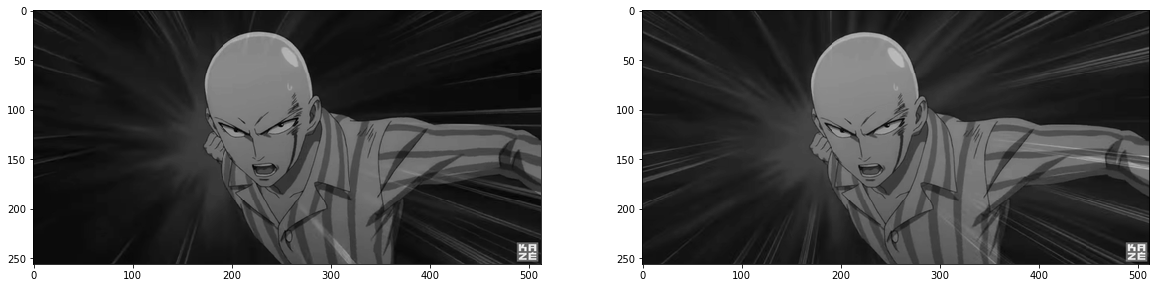

In [137]:
plt.figure(figsize=(20, 9))

plt.subplot(121)
plt.imshow(f1, cmap='gray')

plt.subplot(122)
plt.imshow(f2, cmap='gray')

## Question 1: Motion estimation

### A - Pixel wise method

In [138]:
import progressbar

In [139]:
vxtest = 2
vytest = 1

In [140]:
f1b = f1[0:128,0:128]
f2b = f1[0+vxtest:128+vxtest,0+vytest:128+vytest]


frame_1 = f1b
frame_2 = f2b

def pixel_wise(f1, f2, size_window=8):
    flow = np.zeros(shape=(2, f2.shape[0], f2.shape[1]))
    win = size_window // 2

    ctn = 0

    with progressbar.ProgressBar(max_value=f1.shape[0] * f2.shape[1] * size_window * size_window) as bar:
        for i in range(win, f2.shape[0] - win):
            for j in range(win, f2.shape[1] - win):
                cur = f1[i,j]
                minimal_dist = np.inf
                current_position = (i, j)
                for k in range(i - win, i + win):
                    for l in range(j - win, j + win):
                        dist = np.sqrt((cur - f2[k, l])**2)
                        if (dist < minimal_dist):
                            minimal_dist = dist
                            current_position = (i-k, l-j)
                        bar.update(ctn)
                        ctn += 1
                flow[0, i, j] = current_position[0]
                flow[1, i, j] = current_position[1] 

    return flow

In [141]:
fl = pixel_wise(f1b, f2b)

N/A% (0 of 1048576) |                    | Elapsed Time: 0:00:00 ETA:  --:--:--<ipython-input-140-f9b2c3a948e1>:22: RuntimeWarning: overflow encountered in ushort_scalars
  dist = np.sqrt((cur - f2[k, l])**2)
100% (1048576 of 1048576) |##############| Elapsed Time: 0:00:11 Time:  0:00:11


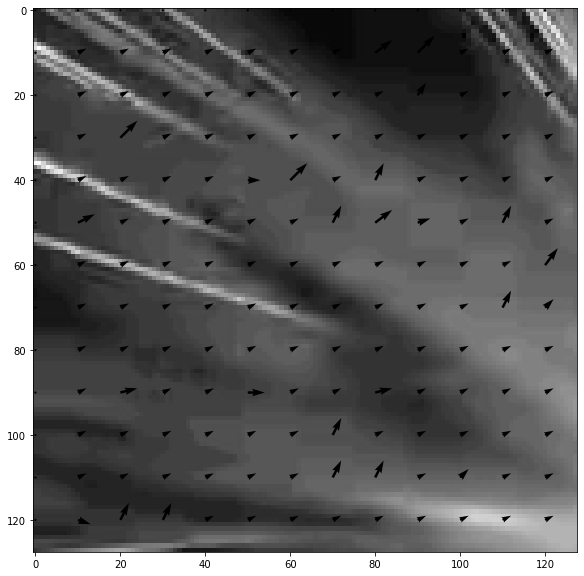

In [142]:
plt.figure(figsize=(15, 10))
plt.imshow(f1b, cmap='gray')
plt.quiver(np.arange(0, f1b.shape[1], 10), np.arange(0, f1b.shape[0], 10), fl[0, ::10, ::10], fl[1, ::10, ::10], angles='xy', scale_units='xy', scale=1.)

<ipython-input-140-f9b2c3a948e1>:22: RuntimeWarning: overflow encountered in ushort_scalars
  dist = np.sqrt((cur - f2[k, l])**2)
100% (8388608 of 8388608) |##############| Elapsed Time: 0:01:27 Time:  0:01:27


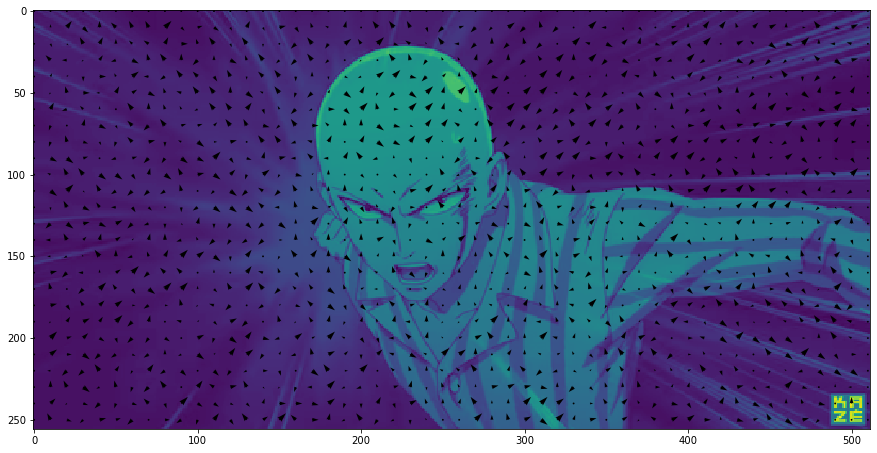

In [143]:
flow = pixel_wise(f1, f2)

plt.figure(figsize=(15, 10))

plt.imshow(f1)

plt.quiver(np.arange(0, f1.shape[1], 10), np.arange(0, f1.shape[0], 10), flow[0, ::10, ::10], flow[1, ::10, ::10], angles='xy', scale_units='xy', scale=1.)

### B - BMA

In [144]:
from skimage.filters.rank import entropy
from skimage.morphology import disk

def SSE(arr_1, arr_2):
    return np.sum((arr_1 - arr_2)**2)


def BMA(frame_1, frame_2, size_block=16, ran=5):
    flow = np.zeros(shape=(2, frame_2.shape[0], frame_2.shape[1]))
    ctn = 0
    with progressbar.ProgressBar(max_value=(frame_1.shape[0] - (2 * size_block + (ran))) * (frame_2.shape[1] - (2 * size_block + (ran))) * ran * ran * 2) as bar:
        for i in range(1, (frame_2.shape[0] - 1) // size_block):
            for j in range(1, (frame_2.shape[1] - 1) // size_block):
                xs = i * size_block
                xe = xs + size_block
                ys = j * size_block
                ye = ys + size_block
                mask_f1 = frame_1[xs:xe, ys:ye]
                best = np.inf
                position = (0, 0)
                for k in range(0, ran):
                    for l in range(0, ran):
                        mask_f2 = frame_2[xs + (k- (ran // 2)):xe+ (k- (ran // 2)), ys + (l- (ran // 2)):ye + (l- (ran // 2))]
                        s = SSE(mask_f1, mask_f2)
                        if (s < best):
                            position = (k - (ran // 2), l - (ran // 2))
                            best = s
                        bar.update(ctn)
                        ctn += 1
                flow[0, xs, ys] = -1 * position[0]
                flow[1, xs, ys] = position[1]
    return flow

In [145]:
im_1 = skimage.color.rgb2gray(skimage.io.imread("metro-bleu.jpg"))
im_1.shape

(1329, 1999)

In [146]:
vxtest = 2
vytest = 0

In [147]:
f1b = f1[128:256,128:256]
f2b = f1[128+vxtest:256+vxtest,128+vytest:256+vytest]

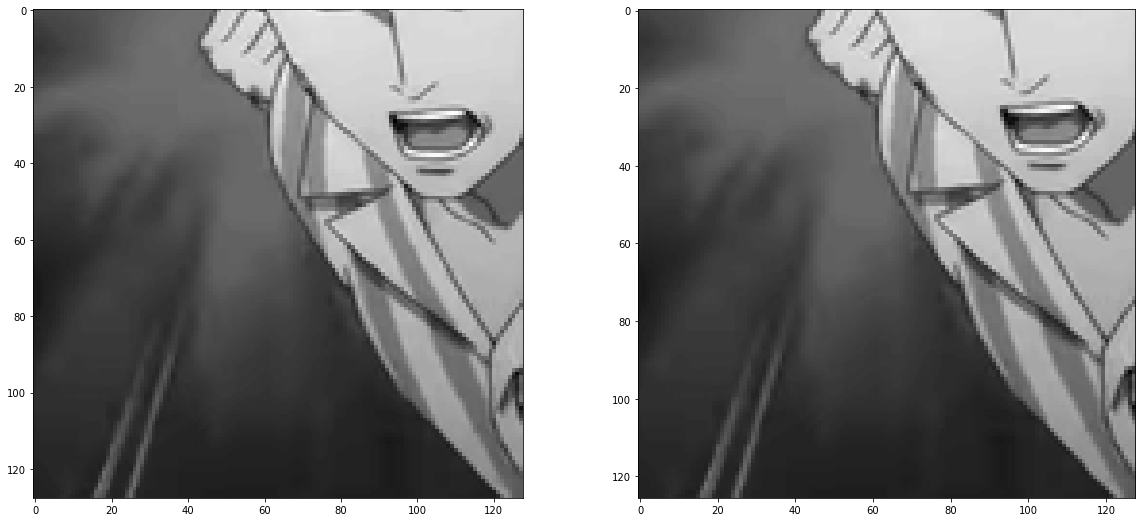

In [148]:
plt.figure(figsize=(20, 9))

plt.subplot(121)
plt.imshow(f1b, cmap='gray')

plt.subplot(122)
plt.imshow(f2b, cmap='gray')

In [160]:
# Definition de la taille des blocs

bloc = 16

In [161]:
flow_t = BMA(f1b, f2b, size_block=bloc)

100% (414050 of 414050) |################| Elapsed Time: 0:00:00 Time:  0:00:00


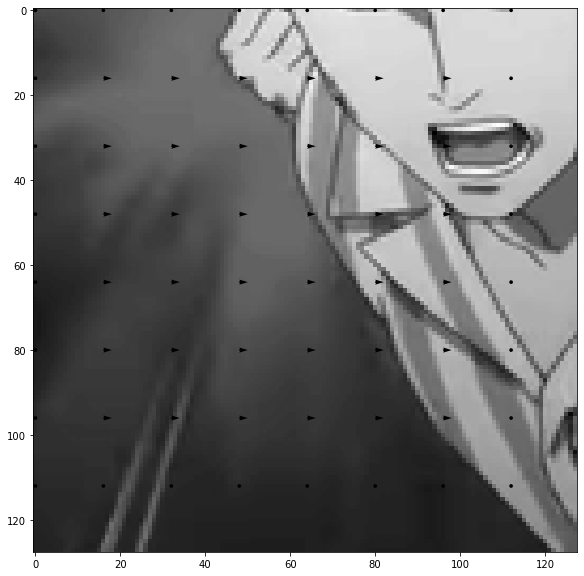

In [162]:
plt.figure(figsize=(15, 10))
plt.imshow(f1b, cmap='gray')
plt.quiver(np.arange(0, f1b.shape[1], bloc), np.arange(0, f1b.shape[0], bloc), flow_t[0, ::bloc, ::bloc], flow_t[1, ::bloc, ::bloc], angles='xy', scale_units='xy', scale=1.)

100% (404950 of 404950) |################| Elapsed Time: 0:00:00 Time:  0:00:00


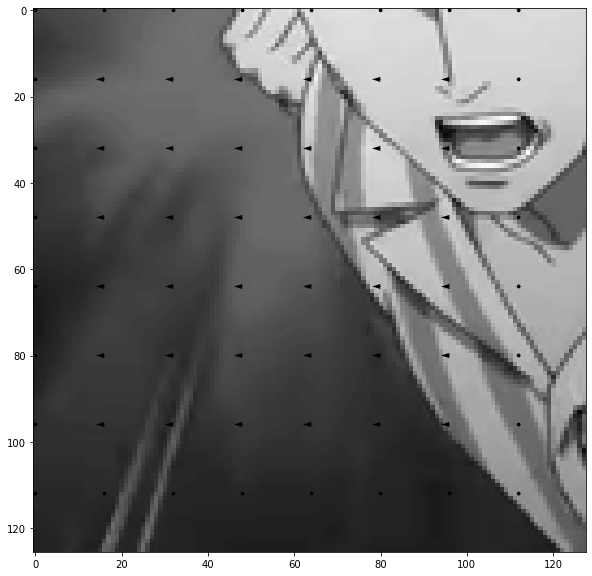

In [164]:
flow_t2 = BMA(f2b, f1b)

plt.figure(figsize=(15, 10))
plt.imshow(f2b, cmap='gray')
plt.quiver(np.arange(0, f2b.shape[1], bloc), np.arange(0, f2b.shape[0], bloc), flow_t2[0, ::bloc, ::bloc], flow_t2[1, ::bloc, ::bloc], angles='xy', scale_units='xy', scale=1.)

100% (5201250 of 5201250) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


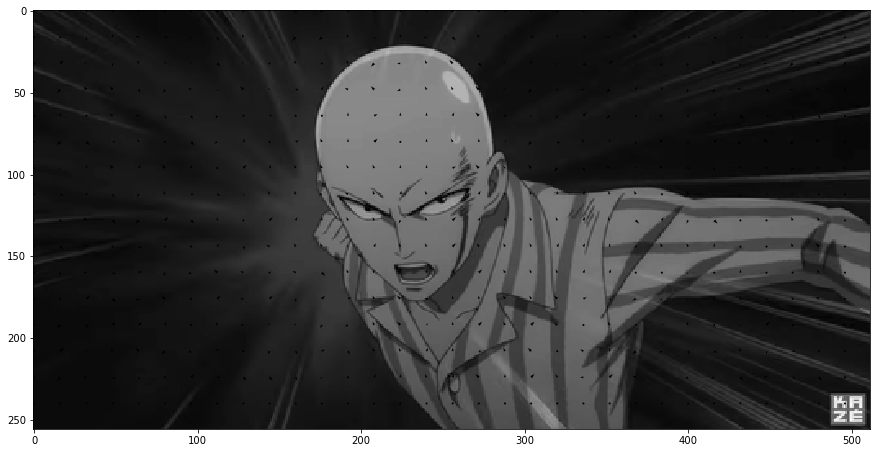

In [165]:
flow = BMA(f1, f2)

plt.figure(figsize=(15, 10))
plt.imshow(f1, cmap='gray')
plt.quiver(np.arange(0, f1.shape[1], bloc), np.arange(0, f1.shape[0], bloc), flow[0, ::bloc, ::bloc], flow[1, ::bloc, ::bloc], angles='xy', scale_units='xy', scale=1.)

##### C - Déduction

Par rapport à la méthode du *pixel_wise*, la méthode du *BMA* est plus précise.

## Question 2 - Motion compensation

### A - estimation du mouvement de F2 -> F1

100% (5201250 of 5201250) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


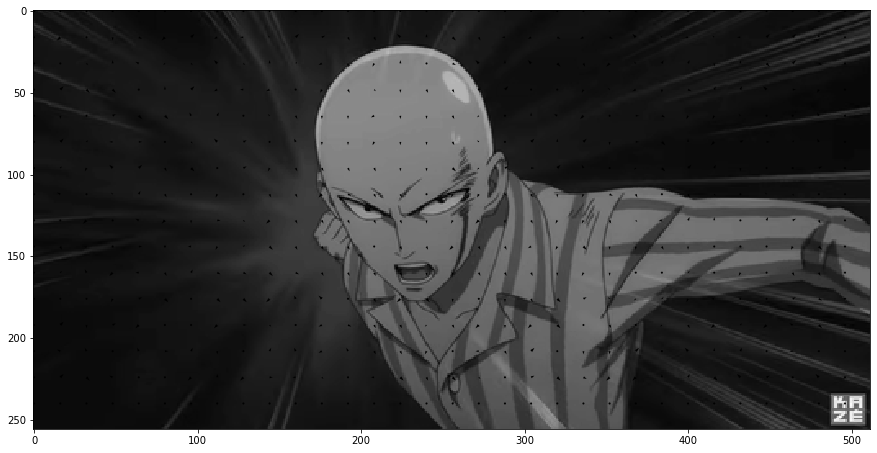

In [166]:
flow2 = BMA(f2, f1)

plt.figure(figsize=(15, 10))
plt.imshow(f1, cmap='gray')
plt.quiver(np.arange(0, f1.shape[1], bloc), np.arange(0, f1.shape[0], bloc), flow2[0, ::bloc, ::bloc], flow2[1, ::bloc, ::bloc], angles='xy', scale_units='xy', scale=1.)

### C - Reconstruction de l'image F2

Reconstruction de l'image

In [181]:
def reconstruct(frame_1, estimation, size_block):
    im = frame_1.copy()
    for i in range(1, frame_1.shape[0] // size_block):
        for j in range(1, frame_1.shape[1] // size_block):
            vx, vy = estimation[0, i * size_block, j * size_block], estimation[1, i * size_block, j * size_block]
            #print(vx, vy)
            for k in range(size_block):
                for l in range(size_block):
                    im[int((i * size_block) + k + vx), int((j  * size_block) + l + vy)] = frame_1[(i * size_block) + k, (j  * size_block) + l]
            #im[int(size_block + vx), int(size_block + vy)] = frame_1[i * size_block, j * size_block]
            
    return im

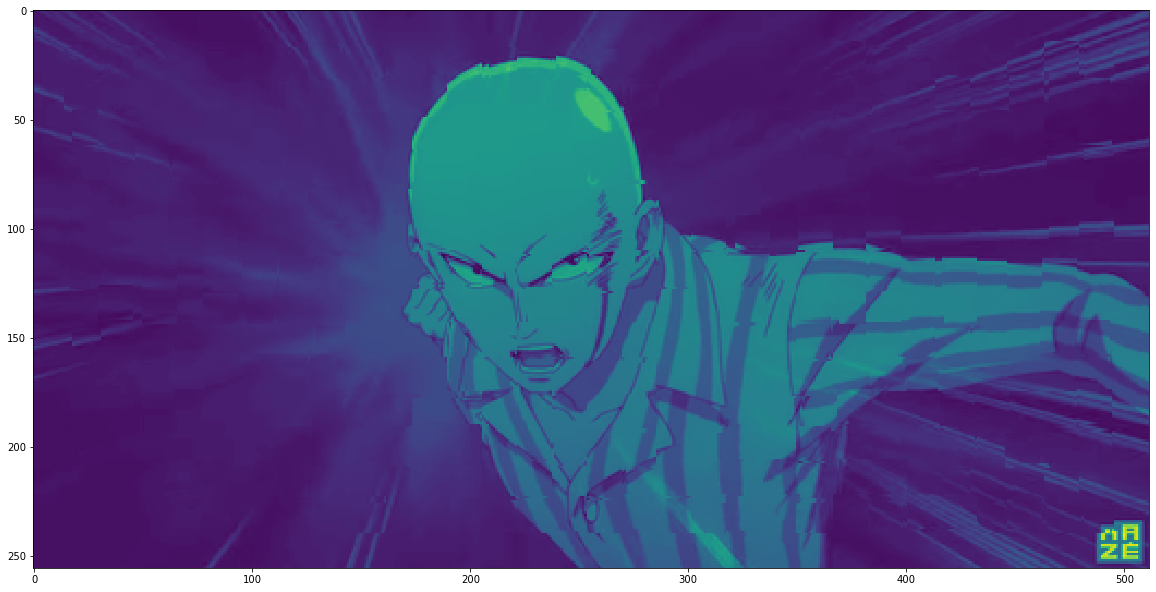

In [182]:
plt.figure(figsize=(20, 16))

plt.imshow(reconstruct(f1, flow, bloc))